In [127]:
import os
from pathlib import Path

if '__setup_done' not in globals():
    os.chdir("..")
    __setup_done = True
    print("디렉토리 변경 완료")
else:
    print("이미 실행됨 - 스킵")

Path.cwd()

이미 실행됨 - 스킵


WindowsPath('d:/02_Projects/Dev/X-ray_AI/Reflecto/runs/exp04_one_genx')

In [128]:
from pathlib import Path

import numpy as np
import torch
from config import CONFIG
from dataset import XRR1LayerDataset
from model import XRR1DRegressor

# -------------------------------------
# 1) 전역 캐시 방지 플래그
# -------------------------------------
if "GLOBAL_MODEL_CACHE" not in globals():
    GLOBAL_MODEL_CACHE = {}

def load_model_once():
    if "model" in GLOBAL_MODEL_CACHE:
        return GLOBAL_MODEL_CACHE["model"], GLOBAL_MODEL_CACHE["dummy_dataset"], GLOBAL_MODEL_CACHE["device"]

    # -------------------------
    # 장치 설정
    # -------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 장치: {device}")

    exp_dir = CONFIG["base_dir"] / CONFIG["exp_name"]
    h5_file = exp_dir / "dataset.h5"
    stats_file = exp_dir / "stats.pt"
    checkpoint_file = exp_dir / "best.pt"

    # -------------------------
    # 모델 생성 + 체크포인트 로드
    # -------------------------
    model = XRR1DRegressor(
        q_len=CONFIG["simulation"]["q_points"],
        n_channels=CONFIG["model"]["n_channels"],
        depth=CONFIG["model"]["depth"],
        mlp_hidden=CONFIG["model"]["mlp_hidden"],
        dropout=CONFIG["model"]["dropout"],
    ).to(device)

    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # -------------------------
    # 정규화 파라미터 로드
    # -------------------------
    dummy_dataset = XRR1LayerDataset(h5_file, stats_file, mode="test",
                val_ratio=CONFIG["training"]["val_ratio"])


    # 캐시에 저장
    GLOBAL_MODEL_CACHE["model"] = model
    GLOBAL_MODEL_CACHE["dummy_dataset"] = dummy_dataset
    GLOBAL_MODEL_CACHE["device"] = device
    return model, dummy_dataset, device


model, dummy_dataset, device = load_model_once()

thicknesses: [66.63255411], roughnesses: [1.821776], slds: [1.37517911]


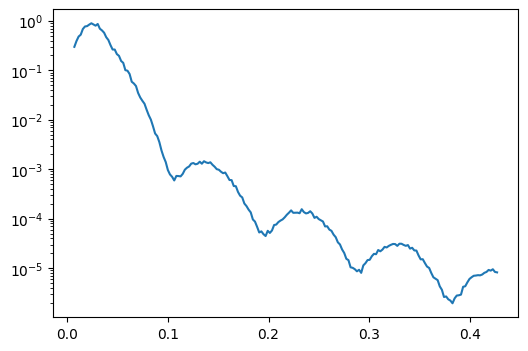

In [ ]:
import matplotlib.pyplot as plt
from reflecto.physics_utils import tth2q
from reflecto.simulate.simul_genx import ParamSet, XRRSimulator

wavelen: float = 1.54  # (nm)
tth_min: float = 0.1   # degree
tth_max: float = 6.0
tth_n: int = 200
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q(tths, wavelen)

xrr_simulator = XRRSimulator(qs, 1, 1)
true_thick, true_rough, true_slds, true_refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {true_thick}, roughnesses: {true_rough}, slds: {true_slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, true_refl)
ax.set_yscale("log")

plt.show()

In [130]:
# -------------------------------------------------------------
# 1️⃣ 실험 Reflectivity 정규화 → 모델 입력 준비
# -------------------------------------------------------------
R_norm, R_max = dummy_dataset.normalize_reflectivity(true_refl)        # (q_len,)
x = R_norm.unsqueeze(0).unsqueeze(0).to(device)            # (1, 1, q_len)

# -------------------------------------------------------------
# 2️⃣ 모델 추론 (정규화된 파라미터)
# -------------------------------------------------------------
with torch.no_grad():
    y_pred_norm = model(x).squeeze().cpu().numpy()         # (3,)

# -------------------------------------------------------------
# 3️⃣ 역정규화 → 실제 물리 파라미터
# -------------------------------------------------------------
y_pred = dummy_dataset.denormalize_params(y_pred_norm)
thickness_pred, roughness_pred, sld_pred = y_pred

print(f"predicted: {thickness_pred}, {roughness_pred}, {sld_pred}")
print(f"true: {true_thick}, {true_rough}, {true_slds}")

predicted: 66.48358154296875, 1.7029985189437866, 1.633967638015747
true: [66.63255411], [1.821776], [1.37517911]


In [131]:
import numpy as np
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# 1) 측정 데이터 준비
qz = qs
R  = true_refl
dR = np.maximum(true_refl*0.3, 1e-8)  # 0 에러 방지 권장

ds = DataSet(name="XRR 1-layer")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

init_param = ParamSet(thickness_pred, roughness_pred, sld_pred)

script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType

initial_thickness = {init_param.thickness}
initial_roughness = {init_param.roughness}
initial_sld = {init_param.sld * 10e-6}  # Å^-2

SI_SLD = 2.07e-6  # Å^-2
initial_I0 = 1.0
class Vars:
    def __init__(self, d, sigma, sld, i0):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
        self._i0 = float(i0)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v): self._sld = float(v)
    def get_sld(self):    return self._sld
    def set_I0(self, v): self._i0 = float(v)
    def get_I0(self):    return self._i0

vars = Vars(initial_thickness, initial_roughness, initial_sld, initial_I0)

Amb  = Layer(d=0.0, dens=0.0, f=0.0)
Sub  = Layer(d = 0.0, f=SI_SLD*1e5, dens=1.0, sigma=3.0)  # ← 1e5
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=vars.get_sld()*1e6,  # _sync와 동일하게 1e6을 곱해줌
             dens=1.0)
SURFACE_SIO2 = Layer(
    d=15.0,
    f=complex(14, 0.1),
    dens=0.05,
    sigma=2.0
)

sample = Sample(Stacks=[Stack(Layers=[SURFACE_SIO2, Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=vars.get_I0(),
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv, # 분해능 컨볼루션
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    Film.f     = vars.get_sld()*1e5
    inst.I0    = vars.get_I0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""
from genx import fom_funcs

# 3) 모델 생성 및 스크립트 설정
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 1. 파라미터 등록 (I0 추가)
pars = Parameters()

# (기존 파라미터들 등록 - 일단 fit=False로 둠)
p_thick = pars.append("vars.set_thickness", model)
p_thick.value = init_param.thickness
p_thick.fit = False  # 일단 끔

p_rough = pars.append("vars.set_roughness", model)
p_rough.value = init_param.roughness
p_rough.fit = False  # 일단 끔

p_sld = pars.append("vars.set_sld", model)
p_sld.value = init_param.sld * 1e-5
p_sld.fit = False    # 일단 끔

# [핵심] I0 파라미터 등록 및 켜기
p_i0 = pars.append("vars.set_I0", model)
p_i0.value = 1.0       # 초기값
p_i0.min = 0.1         # 범위 설정
p_i0.max = 10.0
p_i0.fit = True        # 이것만 켬

model.parameters = pars

# ---------------------------------------------------------
# [단계 1] Linear Scale에서 I0만 피팅
# ---------------------------------------------------------
print("--- Step 1: Fitting I0 in Linear Scale ---")

# FOM 함수를 Linear(chi2 또는 abs_diff)로 변경 [cite: 369, 371]
# fom_funcs.chi2는 (sim - meas)^2 / err^2 의 합입니다.
# 로그를 취하지 않으므로 큰 값(전반사 영역)이 피팅을 지배하게 되어 I0 맞추기에 유리합니다.
model.set_fom_func(fom_funcs.diff)

# I0는 단순한 스케일링이므로 복잡한 dream 대신 'de'나 'amoeba'등 으로 빠르게 끝냅니다.
res_i0 = model.bumps_fit(method="de")
model.bumps_update_parameters(res_i0)

print(f"Fitted I0: {p_i0.value}")

# ---------------------------------------------------------
# [단계 2] Log Scale에서 전체 파라미터 피팅
# ---------------------------------------------------------
print("--- Step 2: Full Fitting in Log Scale ---")

# FOM 함수를 다시 Log로 복구 (반사율 피팅의 표준) [cite: 371]
model.set_fom_func(fom_funcs.log)

# 다른 파라미터들 피팅 켜기
p_thick.fit = True
p_rough.fit = True
p_sld.fit   = True
# I0도 미세 조정을 위해 켜두거나, 고정하고 싶으면 False로 변경
p_i0.fit    = False

# 본격적인 피팅 (DE 또는 DREAM)
res_final = model.bumps_fit(method="de", steps=1000, pop=20, tol=0.01)
model.bumps_update_parameters(res_final)

model.evaluate_sim_func()
print("Final Results:")
for par in model.parameters:
    print(f"  {par.name} = {par.value}")

--- Step 1: Fitting I0 in Linear Scale ---
Fitted I0: 1.0
--- Step 2: Full Fitting in Log Scale ---
Final Results:
   = 0.0
  vars.set_thickness = 66.81091673226356
  vars.set_roughness = 2.573382770607084
  vars.set_sld = 1.4297997744228881e-05
  vars.set_I0 = 1.0


In [132]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()